In [383]:
import numpy as np
from sklearn.base import clone
import random 
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from sklearn.ensemble import BaggingRegressor

In [2]:
tur = pd.read_csv("turkana_raw_w_soils.csv")
nar = pd.read_csv("narok_raw_w_soils.csv")

In [3]:
tur_Q1 = pd.read_csv("Q1_turkana_anomalies.csv")
tur_Q4 = pd.read_csv("Q4_turkana_anomalies.csv")
nar_Q1 = pd.read_csv("Q1_narok_anomalies.csv")
nar_Q4 = pd.read_csv("Q4_narok_anomalies.csv")

In [73]:
tur_Q1.name = "tur_Q1"
tur_Q4.name = "tur_Q4"
nar_Q1.name = "nar_Q1"
nar_Q4.name = "nar_Q4"

In [77]:
# take a sample of turkana and merge soil and lulc data 
def sample_and_merge(df_to_sample, df_to_merge, n):
    df_to_merge_cols = df_to_merge[["Unnamed: 0", 'sand30', 'sand60', 'sand100',
       'silt30', 'silt60', 'silt100', 'clay30', 'clay60', 'clay100', 'soc30',
       'soc60', 'soc100', 'bdod30', 'bdod60', 'bdod100', 'cfvo30', 'cfvo60',
       'cfvo100', 'cropland','grassland', 'shrub', 'trees']]
    df_sampled = df_to_sample.sample(n = n)
    df_merged = df_sampled.merge(df_to_merge_cols, how = "left", left_on = "point_index", right_on = "Unnamed: 0")
    df_merged.name = df_to_sample.name
    
    return (df_merged)

In [365]:
# create datasets - 48 in total 
#base sets are samples and merged anomaly sets
# train test split Q1
t_trainQ1, t_testQ1 = train_test_split(tur_Q1, test_size = .2)
n_trainQ1, n_testQ1 = train_test_split(nar_Q1, test_size = .2)


# train test split Q4
t_trainQ4, t_testQ4 = train_test_split(tur_Q4, test_size = .2)
n_trainQ4, n_testQ4 = train_test_split(nar_Q4, test_size = .2)

# name dataframes
t_trainQ1.name = "tur_Q1_train"
t_testQ1.name = "tur_Q1_test"
n_trainQ1.name = "nar_Q1_train"
n_testQ1.name = "nar_Q1_test"
t_trainQ4.name = "tur_Q4_train"
t_testQ4.name = "tur_Q4_test"
n_trainQ4.name = "nar_Q4_train"
n_testQ4.name = "nar_Q4_test"

#use the full set
base_sets = [sample_and_merge(tur_Q1, tur, len(tur_Q1)), sample_and_merge(tur_Q4, tur, len(tur_Q4)), sample_and_merge(nar_Q1, nar, len(nar_Q1)), sample_and_merge(nar_Q4, nar, len(nar_Q4))]
#create train and test sets for the regression
train_sets = [sample_and_merge(t_trainQ1, tur, len(t_trainQ1)), sample_and_merge(t_trainQ4, tur, len(t_trainQ4)), sample_and_merge(n_trainQ1, nar, len(n_trainQ1)), sample_and_merge(n_trainQ4, nar, len(n_trainQ4))]
test_sets = [sample_and_merge(t_testQ1, tur, len(t_testQ1)), sample_and_merge(t_testQ4, tur, len(t_testQ4)), sample_and_merge(n_testQ1, nar, len(n_testQ1)), sample_and_merge(n_testQ4, nar, len(n_testQ4))]

# sample the full sets
# base_sets = [sample_and_merge(tur_Q1, tur, 10000), sample_and_merge(tur_Q4, tur, 10000), sample_and_merge(nar_Q1, nar, 10000), sample_and_merge(nar_Q4, nar, 10000)]

#soil variable depths to consider
depths = ["30", '60', '100']
# land use to consider
lulc = ['cropland','grassland', 'shrub', 'trees']

#dictionary of dataframe name and dataframe - FULL DATA
def get_dataframes(base_sets):
    powerset_df = []
    powerset_all_depths = []
    for df in base_sets:
        for l in lulc:
            minus_lulc_cols = [col for col in df.columns if col not in lulc]
            lulc_name = (df.name + "_"+ l)
            lulc_df = df[df[l]>0][minus_lulc_cols]
            lulc_df.name = lulc_name
            powerset_all_depths.append(lulc_df)

            for depth in depths: 
                outdf_name = (df.name +"_"+ depth +"_"+ l)
                #pull appropriate soil columns
                select_cols = [col for col in df.columns if depth in col]
                #add back other columns needed
                select_cols.extend(['anomaly_value', '16dayppt_before_date'])
                #subset the original dataframe
                good2go = df[df[l]>0][select_cols]
                good2go.name = outdf_name
                powerset_df.append(good2go)
                
    return (powerset_df, powerset_all_depths)

# get full datasets
powerset_df, powerset_all_depths = get_dataframes(base_sets)
# get train and test datasets
powerset_df_train, powerset_all_depths_train = get_dataframes(train_sets)
powerset_df_test, powerset_all_depths_test = get_dataframes(test_sets)

In [293]:
def heatmap(df):
    RdYlGn = matplotlib.cm.get_cmap("RdYlGn")
    corr_matrix = df.corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corr_matrix,  annot = True, vmax=0.9, square=True, cmap = RdYlGn)
    plt.title(df.name, fontsize = 16);
    file_path = "C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\anomaly_heatmaps\\" + df.name + "_heatmap.jpg"
    plt.savefig(file_path)
    plt.close()

In [288]:
def pairplot(df): 
    sns.set()
    sns.pairplot(df, height = 2.5)
    plt.suptitle(df.name, fontsize = 20, y=1.02)
    file_path = "C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\anomaly_pairplots\\" + df.name + "_pairplot.jpg"
    plt.savefig(file_path)
    plt.close()

In [360]:
for df in powerset_df:
    heatmap(df)
    pairplot(df)

## Regression

In [384]:
# run regression on all datasets
df_scores = {}
df_coeff = {}
for i in range(len(powerset_all_depths_train)):
# for df in powerset_all_depths_train: 
    df_train = powerset_all_depths_train[i]
    df_test = powerset_all_depths_test[i]
    #columns to remove from x
    rm_meX = ['anomaly_value', 'point_index','anomaly_date', 'Unnamed: 0']
    
    #drop na values - where dates are in the first 16 days of january 2014
    df_clean_train = df_train.dropna(axis = 0, how = "any")
    #pull out x and y columns 
    data_x_train = df_clean_train[[col for col in df_train.columns if col not in rm_meX]]
    data_y_train = df_clean_train['anomaly_value']
    #scale x and y values 
    scaled_x_train = MinMaxScaler().fit_transform(data_x_train)
    scaled_y_train = MinMaxScaler().fit_transform(data_y_train.array.reshape(-1,1))
    
    #do the same for the test data
    #drop na values - where dates are in the first 16 days of january 2014
    df_clean_test = df_test.dropna(axis = 0, how = "any")
    #pull out x and y columns 
    data_x_test = df_clean_test[[col for col in df_test.columns if col not in rm_meX]]
    data_y_test = df_clean_test['anomaly_value']
    #scale x and y values 
    scaled_x_test = MinMaxScaler().fit_transform(data_x_test)
    scaled_y_test = MinMaxScaler().fit_transform(data_y_test.array.reshape(-1,1))
    
    #run a linear regression on training data
    # bagged estimator
    reg = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=20, max_samples =.7, bootstrap_features = True, random_state=0).fit(scaled_x_train, scaled_y_train)
#     reg = LinearRegression().fit(scaled_x_train, scaled_y_train)
    
    #save score and coefficients in a dictionary 
    #calculate score based on test data 
    df_scores[df_test.name] = reg.score(scaled_x_test, scaled_y_test)
#     df_coeff[df_train.name] = reg.coef_

C:\Users\Researcher\.conda\envs\research_env\lib\site-packages\sklearn\ensemble\_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
C:\Users\Researcher\.conda\envs\research_env\lib\site-packages\sklearn\ensemble\_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
C:\Users\Researcher\.conda\envs\research_env\lib\site-packages\sklearn\ensemble\_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
C:\Users\Researcher\.conda\envs\research_env\lib\site-packages\sklearn\ensemble\_bagging.py:429: DataConversionWarning: A column-vect

In [385]:
# pull the scores and sort them to put into a heatmap
scores = []
leftaxis = ['nar_Q1', 'nar_Q4', 'tur_Q1', 'tur_Q4']
for a in leftaxis: 
    a_list = []
    keys = [key for key in list(df_scores.keys()) if a in key]
    for k in keys: 
        a_list.append(df_scores[k])
    scores.append(a_list)

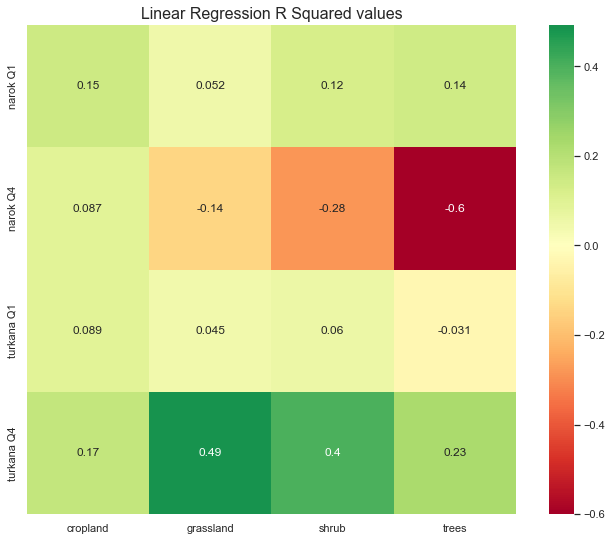

In [387]:
# create regression score heatmap
RdYlGn = matplotlib.cm.get_cmap("RdYlGn")
summer = matplotlib.cm.get_cmap("summer_r")
Yaxes = ['narok Q1', 'narok Q4', 'turkana Q1', 'turkana Q4']
Xaxes = ["cropland", "grassland", "shrub", "trees"]

plt.subplots(figsize=(12,9))
sns.heatmap(scores, annot = True, xticklabels = Xaxes, yticklabels = Yaxes, square=True, cmap = RdYlGn, center = 0)
plt.title("Linear Regression R Squared values", fontsize = 16);
file_path = "C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\Linear_regression_score_heatmap_bagged_test.jpg"
plt.savefig(file_path)

In [374]:
# pull the coefficients and sort them to put into a heatmap
coefficients = []
leftaxis = list(df_coeff.keys())
for a in leftaxis: 
    coefficients.append(list(df_coeff[a].flatten()))

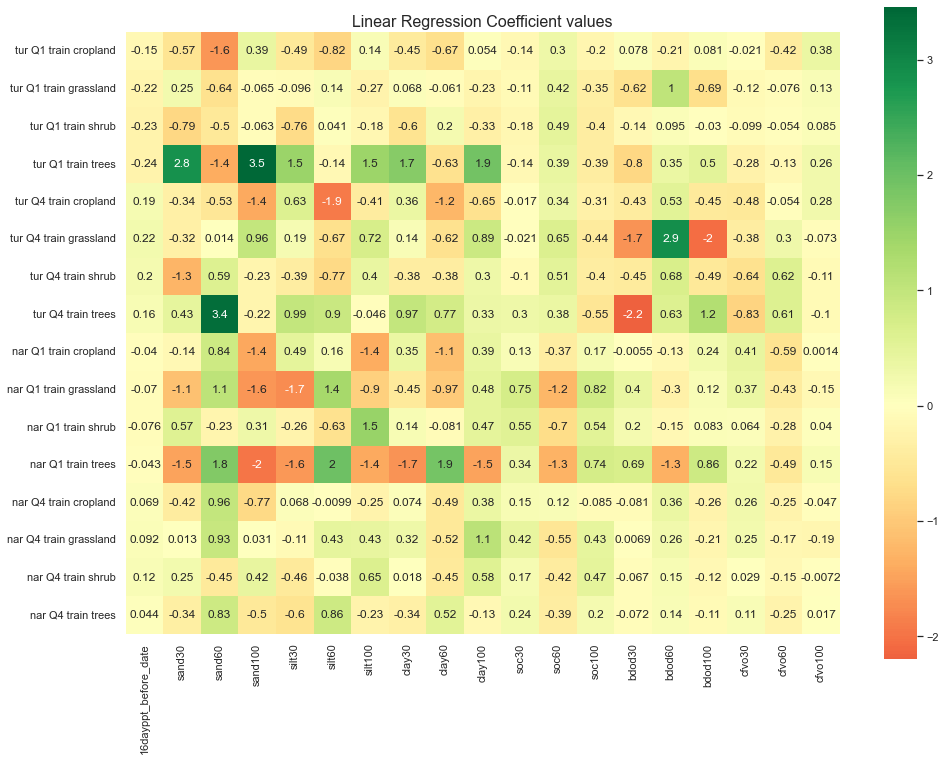

In [376]:
# create regression coefficient heatmap
RdYlGn = matplotlib.cm.get_cmap("RdYlGn")
Yaxes = [col.replace("_", " ") for col in leftaxis]
Xaxes = ['16dayppt_before_date', 'sand30', 'sand60', 'sand100', 'silt30',
       'silt60', 'silt100', 'clay30', 'clay60', 'clay100', 'soc30', 'soc60',
       'soc100', 'bdod30', 'bdod60', 'bdod100', 'cfvo30', 'cfvo60', 'cfvo100']

plt.subplots(figsize=(16,12))
sns.heatmap(coefficients, annot = True, xticklabels = Xaxes, yticklabels = Yaxes, square=True, cmap = RdYlGn, center = 0)
plt.title("Linear Regression Coefficient values", fontsize = 16);
file_path = "C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\Linear_regression_coeff_heatmap.jpg"
plt.savefig(file_path)

## Data Exploration

In [391]:
powerset_df[0].name

'tur_Q1_30_cropland'

In [397]:
# plotting functino 
def scatter_tex(df):
    # plot all pixels annual mean2014 ndvi versus soil texture 
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=True)) # frameon=False removes frames
    
    plt.subplots_adjust(hspace=.0)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    
    cols = df.columns
    sand = [col for col in cols if "sand" in col][0]
    silt = [col for col in cols if "silt" in col][0]
    clay = [col for col in cols if "clay" in col][0]

    ax1.scatter(df[sand]/10, df['anomaly_value'], s = .5, color = 'red', label = "Sand")
    ax1.text(1.0, 0.5, "Sand",
            rotation=270, size=12, color = 'red', va='center', transform=ax1.transAxes)
    # ax1.plot(df['sand_15_30']/10,sap(df['sand_15_30']/10),"b--")

    ax2.scatter(df[silt]/10, df['anomaly_value'], s = .5, color = 'blue', label = "Silt")
    ax2.text(1.0, 0.5, "Silt",
            rotation=270, size=12, color = 'blue', va='center', transform=ax2.transAxes)
    # ax2.plot(df['silt_15_30']/10,sip(df['silt_15_30']/10),"b--")

    ax3.scatter(df[clay]/10, df['anomaly_value'], s = .5, color = 'green', label = "Clay")
    ax3.text(1.0, 0.5, "Clay",
            rotation=270, size=12, color = 'green', va='center', transform=ax3.transAxes)
    # ax3.plot(df['clay_15_30']/10,clp(df['clay_15_30']/10),"b--")
    title = df.name.replace("_", " ")
    path = "C:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\soil_vs_anomaly_plots\\" + df.name + "_soil_v_anom_plot.jpg"
    plt.suptitle(title)
    fig.text(0.5, 0.02, 'Percentage of Topsoil', ha='center')
    fig.text(0.04, 0.5, 'NDVI anomaly', va='center', rotation='vertical')
    plt.savefig(path, dpi = 500)
    plt.close()

In [398]:
for df in powerset_df: 
    scatter_tex(df)

## Regression Trees

In [29]:
def pull_reg_cols(df):
    # pull columns from narok dataframe
    all_columns = df.columns
    #ppt columns
    ppt_columns = [col for col in all_columns if 'ppt' in col]
    # soil columns     
    soil_columns = [col for col in all_columns if 'sand' in col or 'silt' in col or 'clay' in col or 'soc' in col or 'bdod' in col or 'cfvo' in col]
    #lulc
    lulc = ['cropland','grassland', 'shrub', 'trees']
    #target ndvi columns 
    target = [col for col in all_columns if 'ndvi' in col]

    to_keep = ppt_columns + soil_columns + lulc + target
    reg_df = df[to_keep]
    return (reg_df)

In [30]:
tur_reg = pull_reg_cols(tur)
nar_reg = pull_reg_cols(nar)

In [33]:
# train test split 
t_train, t_test = train_test_split(tur_reg, test_size = .2)
n_train, n_test = train_test_split(nar_reg, test_size = .2)

In [400]:
powerset_all_depths[0].columns

Index(['point_index', 'anomaly_date', 'anomaly_value', '16dayppt_before_date',
       'Unnamed: 0', 'sand30', 'sand60', 'sand100', 'silt30', 'silt60',
       'silt100', 'clay30', 'clay60', 'clay100', 'soc30', 'soc60', 'soc100',
       'bdod30', 'bdod60', 'bdod100', 'cfvo30', 'cfvo60', 'cfvo100'],
      dtype='object')

In [401]:
from sklearn.tree import DecisionTreeRegressor

class BaggingClassifier:
    def __init__(self, ratio = 0.73, N = 20, base=DecisionTreeRegressor(max_depth=4)):
#     def __init__(self, ratio = 0.73, N = 20, base=LinearRegression()):

        """
        Create a new BaggingClassifier
        
        Args:
            base (BaseEstimator, optional): Sklearn implementation of decision tree
            ratio: ratio of number of data points in subsampled data to the actual training data
            N: number of base estimator in the ensemble
        
        Attributes:
            base (estimator): Sklearn implementation of decision tree
            N: Number of decision trees
            learners: List of models trained on bootstrapped data sample
        """ 
        
        assert ratio <= 1.0, "Cannot have ratio greater than one"
        self.base = base
        self.ratio = ratio
        self.N = N
        self.learners = []
        
#     def get_params(self, deep=True):
#         # suppose this estimator has parameters "alpha" and "recursive"
#         return {"base": self.base, "ratio": self.ratio, "N": self.N, "learners": self.learners}

#     def set_params(self, **parameters):
#         for parameter, value in parameters.items():
#             setattr(self, parameter, value)
#         return self
        
    def fit(self, X_train, y_train):
        """
        Train Bagging Ensemble Classifier on data
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        #TODO: Implement functionality to fit models on the bootstrapped samples
        # cloning sklearn models:
        # from sklearn.base import clone
        # h = clone(self.base)
        
        from sklearn.base import clone
                
        # clone the base model, train a model on a boostrapped training set
        # do this N times 
        learn_list = []
        for i in range(self.N):
            h = clone(self.base, safe = False)
            boot_x, boot_y = self.bootstrap(X_train, y_train)
            fitted_h = h.fit(boot_x, boot_y)
            learn_list.append(fitted_h)
            self.learners = learn_list
        
        
    def bootstrap(self, X_train, y_train):
        """
        Args:
            n (int): total size of the training data
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        # Take in all training data, sample data uniformly with replacement 
        # number of samples in training data
        n = len(X_train)
        
        # uniformly sample indices with replacement, use these indices to pull training data and labels 
        # select n*ratio samples to use for bootstrapped training set
        indices = random.choices(range(n), k = int(n*self.ratio))
        
        # boostrapped X and Y 
        boot_x = [X_train[i] for i in indices]
        boot_y = [y_train[i] for i in indices]
        
        return (boot_x, boot_y)
        
    
    def predict(self, X):
        """
        BaggingClassifier prediction for data points in X
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns:
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """
        
        #TODO: Using the individual classifiers trained predict the final prediction using voting mechanism
        predictions = self.voting(X)
        return (predictions)
    
    def voting(self, y_hats):
        """
        Args:
            y_hats (ndarray): [N] ndarray of data
        Returns:
            y_final : int, final prediction of the 
        """
        #TODO: Implement majority voting scheme and incase of ties return random label
                
        # save list of arrays of predictions for each of the boostrapped models in the learners list
        learner_predictions = []
        
        # save the final voted predictions
        voted_predictions = []
        
        # iterate over each of the models, predict values for y_hats
        for i in range(self.N):
            model = self.learners[i]
            model_predictions = model.predict(y_hats)
            # append to list of arrays of predictions
            learner_predictions.append(model_predictions.copy())
        
        # make one array with all of the arrays in learner predictions 
        # each array of predictions for the y_hat points will be one row in the array
        # number of rows = N, one row for each model
        # number of columns = len(y_hats), one column for each data point being predicted
        stacked_predictions = np.vstack(learner_predictions)
        
        # transpose the above so that each row is the predictions for a given y_hat point
        # each column is a model 
        # each row is a point 
        per_point_preds = stacked_predictions.T
        
        # iterate all of the rows in per_point_preds, i.e. iterate over each point passed into the function
        for i in range(per_point_preds.shape[0]):
            # for each row/point, count the number of 1s and -1s and then decide what the 
            # voted prediction is for that point, append to voted_predictions
            ones = list(per_point_preds[i]).count(1)
            neg_ones = list(per_point_preds[i]).count(-1)
            if ones > neg_ones:
                voted_predictions.append(1)
            elif ones < neg_ones:
                voted_predictions.append(-1)
            else: 
                voted_predictions.append(random.choice([-1, 1]))
                
        # return the voted predictions 
        return(voted_predictions)
            

In [402]:
# split training data using sklearn library 
from sklearn.model_selection import KFold
K_fold = KFold(n_splits=5, shuffle = True)    

In [411]:
def subset_x_y(df):
    x_cols = [col for col in df.columns if col not in ['point_index', 'anomaly_date', 'anomaly_value', 'Unnamed: 0']]
    y_col = ['anomaly_value']
    x_arr = df[x_cols].to_numpy()
    y_arr = df[y_col].to_numpy()
    
    return(x_arr, y_arr)

In [408]:
powerset_all_depths_train[0].name

'tur_Q1_train_cropland'

In [416]:
accuracy_list = {}
for df in powerset_all_depths_train: 
    name = df.name
    df_clean_train = df.dropna(axis = 0, how = "any")
    X_train, y_train = subset_x_y(df_clean_train)
    # to explore accuracy vs. N values 
    # initialize BaggingClassifier 
    bag_class = BaggingClassifier(N = 5)
    
    kf_accuracy = []
    # complete kfold training of model with value of N
    k_count = 0
    for train_ind, test_ind in K_fold.split(X_train, y_train):
        k_count+= 1
        # train BaggingClassifier on train data 
        bag_class.fit(X_train[train_ind], y_train[train_ind])
        # predict on test data 
        predictions = bag_class.predict(X_train[test_ind])
        # check accuracy on this k fold, save in list 
        accuracy = sklearn.metrics.r2_score(y_train[test_ind], predictions)

        # add accuracy of this fold to the list
        kf_accuracy.append(accuracy)
        print ("k fold _",k_count, " done.")

    # what is the average accuracy of the k fold classifiers trained with parameter N
    avg_acc_N = sum(kf_accuracy) / len(kf_accuracy)
    accuracy_list[name] = avg_acc_N
    print (name, " done.")

k fold _ 1  done.
k fold _ 2  done.
k fold _ 3  done.
k fold _ 4  done.
k fold _ 5  done.
tur_Q1_train_cropland  done.
k fold _ 1  done.
k fold _ 2  done.
k fold _ 3  done.
k fold _ 4  done.
k fold _ 5  done.
tur_Q1_train_grassland  done.
k fold _ 1  done.
k fold _ 2  done.
k fold _ 3  done.
k fold _ 4  done.
k fold _ 5  done.
tur_Q1_train_shrub  done.
k fold _ 1  done.
k fold _ 2  done.
k fold _ 3  done.
k fold _ 4  done.
k fold _ 5  done.
tur_Q1_train_trees  done.
k fold _ 1  done.
k fold _ 2  done.
k fold _ 3  done.
k fold _ 4  done.
k fold _ 5  done.
tur_Q4_train_cropland  done.
k fold _ 1  done.
k fold _ 2  done.
k fold _ 3  done.
k fold _ 4  done.
k fold _ 5  done.
tur_Q4_train_grassland  done.
k fold _ 1  done.
k fold _ 2  done.
k fold _ 3  done.
k fold _ 4  done.
k fold _ 5  done.
tur_Q4_train_shrub  done.
k fold _ 1  done.
k fold _ 2  done.
k fold _ 3  done.
k fold _ 4  done.
k fold _ 5  done.
tur_Q4_train_trees  done.
k fold _ 1  done.
k fold _ 2  done.
k fold _ 3  done.
k fo

In [417]:
accuracy_list

{'tur_Q1_train_cropland': -731.6401628163219,
 'tur_Q1_train_grassland': -794.7212102814594,
 'tur_Q1_train_shrub': -679.2437345337523,
 'tur_Q1_train_trees': -282.07072314515176,
 'tur_Q4_train_cropland': -215.15149677373634,
 'tur_Q4_train_grassland': -190.2679098225833,
 'tur_Q4_train_shrub': -167.5985884568012,
 'tur_Q4_train_trees': -147.52153661562812,
 'nar_Q1_train_cropland': -233.43112654274177,
 'nar_Q1_train_grassland': -244.6205138658951,
 'nar_Q1_train_shrub': -464.9758487060857,
 'nar_Q1_train_trees': -133.9447311660791,
 'nar_Q4_train_cropland': -299.6888978361878,
 'nar_Q4_train_grassland': -272.9638318660592,
 'nar_Q4_train_shrub': -332.04690905939873,
 'nar_Q4_train_trees': -418.90421813473415}